In [1]:
import numpy as np
from scripts.mesh import *
from scripts.simulation import *

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

font = {'family' : 'normal',
        'size'   : 24}

matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = (12,8)

In [2]:
def generate_degree_ratio(degree, low):
    if degree < 3:
        low = 1
    return np.random.uniform(low,1)
        
def generate_mesh_settings(grid_size,N1=False):
    mesh_degree_settings = MESH_DEGREE_SETTINGS
    mesh_settings = MESH_SETTINGS
    
    mesh_settings['grid_size'] = grid_size
    mesh_settings['contraction_ratio'] = np.random.uniform(0,0.25)
    mesh_settings['N-1'] = N1
    
    mesh_degree_settings[6] = generate_degree_ratio(6,0)
    mesh_degree_settings[5] = generate_degree_ratio(5,0)
    mesh_degree_settings[4] = generate_degree_ratio(4,0)
    mesh_degree_settings[3] = generate_degree_ratio(3,0.2)
#     mesh_degree_settings[2] = generate_degree_ratio(2,0.2)
    
    return mesh_settings

In [3]:
def mc_degree_impact(mesh,fail_rate,degree,valid_pids,num_sim = 100):
    pool = mp.Pool(mp.cpu_count()-1)
    results = pool.starmap(degree_impact, [(mesh,fail_rate,degree,valid_pids) for _ in range(num_sim)])
    pool.close()
    
    directs,unintends = [],[]
    for direct,unintend in results:
        directs.append(direct)
        unintends.append(unintend)
        
    return np.mean(directs)/len(valid_pids),np.mean(unintends)/len(valid_pids)

In [4]:
def multi_degree_impact(mesh,fail_rate,degree_list):
    degree_result = []
    for degree in degree_list:
        results = mc_degree_impact(mesh,fail_rate,degree,mesh.valid_pids,30)
        degree_result.append(results)
    return degree_result
    

In [5]:
fail_rate = 0.25
degree_list = list(range(1,10,2))
mc_num = 500
grid_size = 15

In [ ]:
mc_results = []
sparsity = []
num_sim = 0
while num_sim < mc_num:
    try:
        mesh_setting = generate_mesh_settings(grid_size, True)
        mesh = create_mesh(mesh_setting)
        sparseness = calculate_sparseness(mesh)
        print (f'sparseness of the created mesh (compare to the grid network) {sparseness}')
    except:
        continue
    result = multi_degree_impact(mesh,fail_rate,degree_list)
    mc_results.append(result) 
    sparsity.append(sparseness)
    num_sim+=1

sparseness of the created mesh (compare to the grid network) 0.45918367346938777
sparseness of the created mesh (compare to the grid network) 0.5
sparseness of the created mesh (compare to the grid network) 0.6275510204081632
sparseness of the created mesh (compare to the grid network) 0.6224489795918368
sparseness of the created mesh (compare to the grid network) 0.6377551020408163
sparseness of the created mesh (compare to the grid network) 0.5612244897959183
sparseness of the created mesh (compare to the grid network) 0.5204081632653061
sparseness of the created mesh (compare to the grid network) 0.5306122448979592
sparseness of the created mesh (compare to the grid network) 0.4387755102040816
sparseness of the created mesh (compare to the grid network) 0.33163265306122447
sparseness of the created mesh (compare to the grid network) 0.3469387755102041
sparseness of the created mesh (compare to the grid network) 0.5408163265306123
sparseness of the created mesh (compare to the grid n

In [15]:
direct_results = [[],[],[],[],[]]
unintend_results = [[],[],[],[],[]]
for result in mc_results:
    for i in range(len(degree_list)):
        direct_results[i].append(result[i][0])
        unintend_results[i].append(result[i][1])
        
    
    

In [16]:
unintend_results

[[0.004393835616438356,
  0.002732912723449001,
  0.008496296296296299,
  0.0022597014925373133,
  0.012118279569892471,
  0.010706451612903227,
  0.07887423312883438,
  0.009515923566878984,
  0.005032846715328466,
  0.006780986762936221,
  0.02583088235294117,
  0.0011380042462845008,
  0.004686094069529653,
  0.005254413291796469,
  0.01926119402985075,
  0.01491476407914764,
  0.001860623781676413,
  0.013325830653804932,
  0.003437440305635148,
  0.0021566666666666665,
  0.0012602436323366556,
  0.008359580052493439,
  0.02200612745098039,
  0.0007848837209302324,
  0.023065277777777782,
  0.005863849765258216,
  0.00996171802054155,
  0.021368998628257887,
  0.00228135593220339,
  0.004698924731182795,
  0.010757270693512304,
  0.0032553846153846157,
  0.003035267349260523,
  0.0034801587301587296,
  0.068904953145917,
  0.04776811594202899,
  0.018697986577181212,
  0.002433846153846154,
  0.004512605042016807,
  0.04047368421052632,
  0.0021771144278606965,
  0.0079762900976290

In [17]:
def plot_mc_multi_consequence(sparsity,direct,unintend,degree):
    plt.scatter(sparsity, direct, label="direct")
    plt.scatter(sparsity, unintend, label="unintend")
    plt.title(f'Consequence of isolate {degree} pipes')
    plt.xlabel('meshness')
    plt.ylabel('Avg impact ratio')
    plt.legend()
    plt.show()

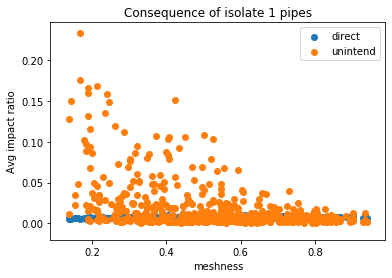

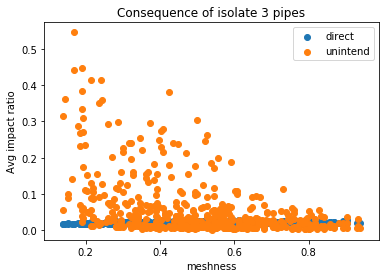

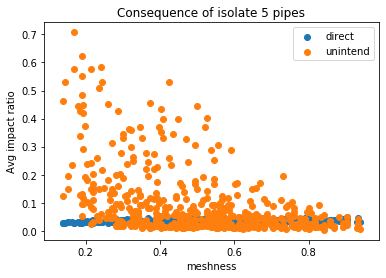

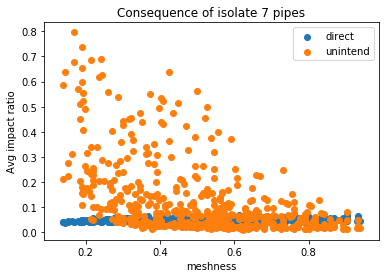

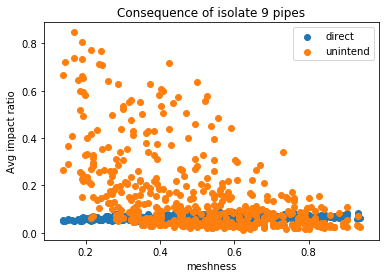

In [18]:
for i in range(len(degree_list)):
    plot_mc_multi_consequence(sparsity,direct_results[i],unintend_results[i],degree_list[i])

In [19]:
def get_sp_degree(sparsity,num_class = 10):
    interval = 1/num_class
    for i in range(num_class):
        if sparsity<interval*(i+1):
            return i

def create_consequence_df(sparsity,direct,unintend):
    conse_type = len(direct)*['direct']+len(unintend)*['unintend']
    sparsities = sparsity+sparsity
    sparsity_degree = [get_sp_degree(sp) for sp in sparsities]
    df_dict = {
        'sparsity':sparsities,
        'mesh_degree':sparsity_degree,
        'consequence':direct+unintend,
        'type':conse_type
    }
    return pd.DataFrame.from_dict(df_dict)

In [20]:
df1 = create_consequence_df(sparsity,direct_results[i],unintend_results[i])

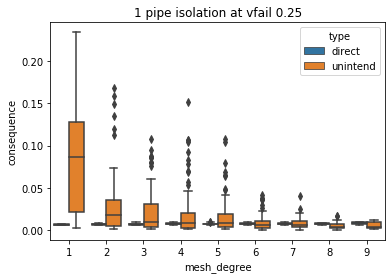

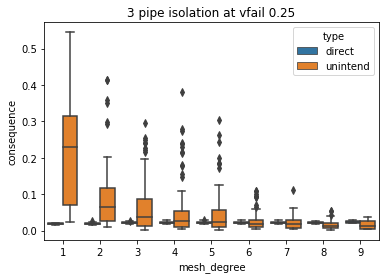

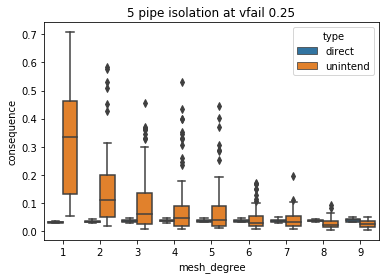

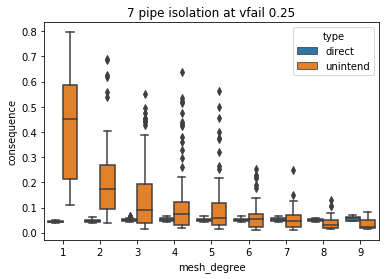

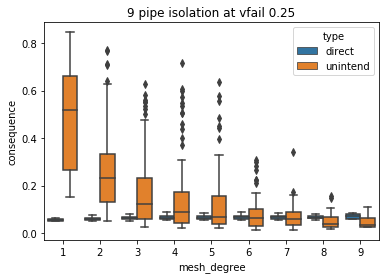

In [21]:
# plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
for i,k in enumerate(degree_list):
    fig = plt.figure()
    df = create_consequence_df(sparsity,direct_results[i],unintend_results[i])
    ax = sns.boxplot(x="mesh_degree", y="consequence", hue="type",
                    data=df).set_title(f'{k} pipe isolation at vfail 0.25')

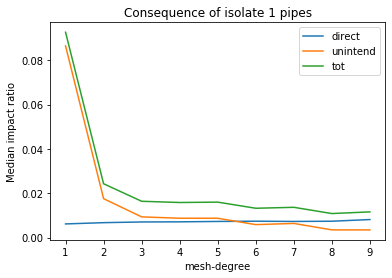

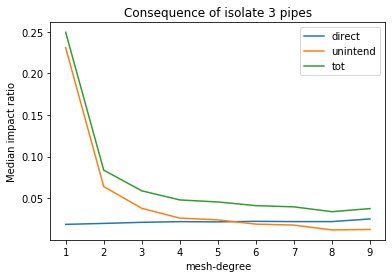

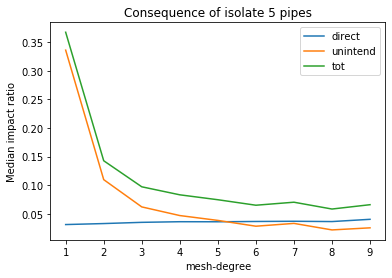

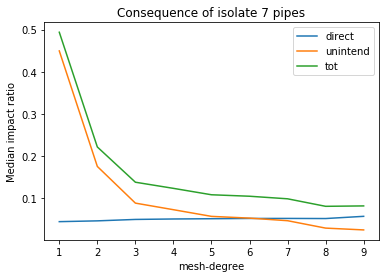

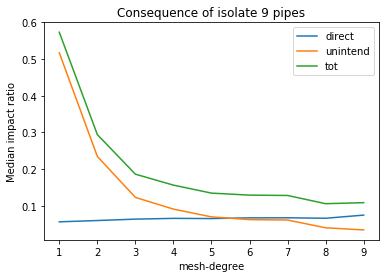

In [22]:
for i,k in enumerate(degree_list):
    fig = plt.figure()
    df = create_consequence_df(sparsity,direct_results[i],unintend_results[i])
    df_direct = df[df['type'] == 'direct'].groupby('mesh_degree', as_index=False).median()
    df_unintend = df[df['type'] == 'unintend'].groupby('mesh_degree', as_index=False).median()
    
    plt.plot(df_direct['mesh_degree'], df_direct['consequence'], label="direct")
    plt.plot(df_unintend['mesh_degree'], df_unintend['consequence'], label="unintend")
    plt.plot(df_unintend['mesh_degree'], df_direct['consequence']+df_unintend['consequence'], 
             label="tot")
    plt.title(f'Consequence of isolate {k} pipes')
#     plt.bar(pids2sim, direct_ratio+unintend_ratio, label="tot")
    
    plt.xlabel('mesh-degree')
    plt.ylabel('Median impact ratio')
    plt.legend()
    plt.show()

#     ax = sns.pointplot(x='sparsity_degree', y='consequence',
#                        data=df_direct)
#     ax = sns.pointplot(x='sparsity_degree', y='consequence',
#                        data=df_unintend.groupby('sparsity_degree', as_index=False).median(),ax = ax)